Гипотезы:
1. доминирование количества мужских персонажей в пьесах не зависит от страны написания;
2. доминирование мужских персонажей в пьесах также отражается на средней длине реплик (реплики мужских персонажей занимают больше половины текста) и не зависит от языка;
3. протагонист пьесы (персонаж с наибольшей длиной реплик) в большинстве пьес - мужчина (вне зависимости от языка);
4. более эмоциональная речь (больше восклицаний) у женских персонажей. 

(еще было бы интересно посмотреть, есть ли взаимосвязь между полом автора и доминирующим полом в пьесе)

*Гипотезы 2 и 3 хорошо бы проверять отдельно сначала для кажой пьесы в языке, а потом для среднего по языку*

In [ ]:
!pip install pydracor

In [ ]:
import random
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pydracor import *

In [ ]:
dracor = DraCor()
dracor.corpora_names()


['als',
 'bash',
 'cal',
 'fre',
 'ger',
 'gersh',
 'greek',
 'hun',
 'ita',
 'rom',
 'rus',
 'shake',
 'span',
 'swe',
 'tat']

In [ ]:
def sort_key(dict):
  return len(dict['text'])

def main_character_gender(play):
  return sorted(play.spoken_text_by_character(), key=sort_key, reverse=True)[0]['gender']

def exclamation_count(play, emotionality):
  lines_per_character = play.spoken_text_by_character()


  for char in lines_per_character:
    emotionality['play_id'].append(play.id)
    emotionality['char_id'].append(char['id'])
    emotionality['gender'].append(char['gender'])
    emotionality['n_of_exclamation'].append(str(char['text']).count('!') / (len(char['text']) + 1))


  return emotionality

def dramas_per_lang(lang_name):
  corpus = Corpus(lang_name)

  res = {'lang_name': [],
         'author': [],
         'play_id': [], 
         'year': [], 
         'f_ratio': [],
         'f_lines_ratio': [],
         'main_character_gender': []}
  all_plays = random.choices(corpus.play_ids(), k=2)  # all_plays = corpus.play_ids()

  for play_id in all_plays:
    print(play_id)
    play = Play(play_id)

    f_ratio = play.num_of_female_characters / (play.num_of_female_characters + play.num_of_male_characters + play.num_of_unknown_characters)
    f_lines_ratio = len(play.spoken_text(gender='FEMALE')) / (len(play.spoken_text(gender='FEMALE')) + len(play.spoken_text(gender='MALE')) + len(play.spoken_text(gender='UNKNOWN')))
    year = play.year_normalized
    main_character = main_character_gender(play)
    name = play.authors[0]['name']

    res['lang_name'].append(lang_name)
    res['author'].append(name)
    res['play_id'].append(play_id)
    res['year'].append(year)
    res['f_ratio'].append(f_ratio)
    res['f_lines_ratio'].append(f_lines_ratio)
    res['main_character_gender'].append(main_character)



    emotionality = {'play_id': [], 
                    'char_id': [], 
                    'gender': [], 
                    'n_of_exclamation': []}
    emotionality = exclamation_count(play, emotionality)

  return pd.DataFrame(res), pd.DataFrame(emotionality)



**Апи очень медленно работает, пришлось сократить выборку очень сильно. Поэтому все выводы очень условны.**

Интересно посмотреть, что в шведском, более подробно, потому что там мужских и женских персонажей почти поровну.

In [ ]:
all_langs = ['rus', 'swe']  # all_langs = dracor.corpora_names()

In [ ]:
con = sqlite3.connect("drama.db")
c = con.cursor()
c.execute("DROP TABLE IF EXISTS male_female_ratio")
c.execute("CREATE TABLE IF NOT EXISTS male_female_ratio(lang_name, author, play_id, year, f_ratio, f_lines_ratio, main_character_gender)")

c.execute("DROP TABLE IF EXISTS emotionality")
c.execute("CREATE TABLE IF NOT EXISTS emotionality(play_id, char_id, gender, n_of_exclamation)")

for lang in all_langs:
  male_female_ratio_df, emotionality = dramas_per_lang(lang)

  for ind, row in male_female_ratio_df.iterrows():
    c.execute("INSERT INTO male_female_ratio VALUES (?, ?, ?, ?, ?, ?, ?)", (row['lang_name'],
                                                                             row['author'],
                                                                             row['play_id'],
                                                                             row['year'],
                                                                             row['f_ratio'],
                                                                             row['f_lines_ratio'],
                                                                             row['main_character_gender']))
  for ind, row in emotionality.iterrows():
    c.execute("INSERT INTO emotionality VALUES (?, ?, ?, ?)", (row['play_id'],
                                                                  row['char_id'],
                                                                  row['gender'],
                                                                  row['n_of_exclamation']))

  con.commit()
con.close()

rus000051
rus000157
swe000049
swe000049


In [ ]:
con = sqlite3.connect("drama.db")
c = con.cursor()

act_query = """
SELECT lang_name, f_ratio, f_lines_ratio, main_character_gender, author, year 
FROM male_female_ratio
"""

df = pd.read_sql_query(act_query, con=con)
print(df.head())

con.close()

  lang_name   f_ratio  f_lines_ratio main_character_gender  \
0       rus  0.200000       0.020468                  MALE   
1       rus  0.222222       0.124705                  MALE   
2       swe  0.187500       0.198810                  MALE   
3       swe  0.187500       0.198810                  MALE   

                           author  year  
0      Гоголь, Николай Васильевич  1836  
1  Судовщиков, Николай Родионович  1802  
2              Strindberg, August  1881  
3              Strindberg, August  1881  


Text(0, 0.5, 'Mean female characters ratio')

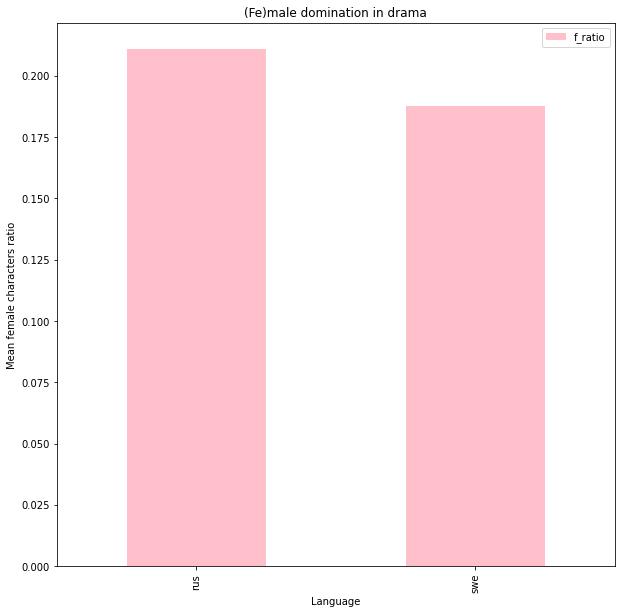

In [ ]:
df.groupby('lang_name').agg({"f_ratio": "mean"}).sort_values(by="lang_name").plot.bar(color='pink', figsize=(10, 10))
plt.title('(Fe)male domination in drama')
plt.xlabel('Language')
plt.ylabel('Mean female characters ratio')

Преобладание мужских персонажей сохраняется во всех языках -> гипотеза 1 подтвердилась

Text(0, 0.5, 'Mean female lines ratio')

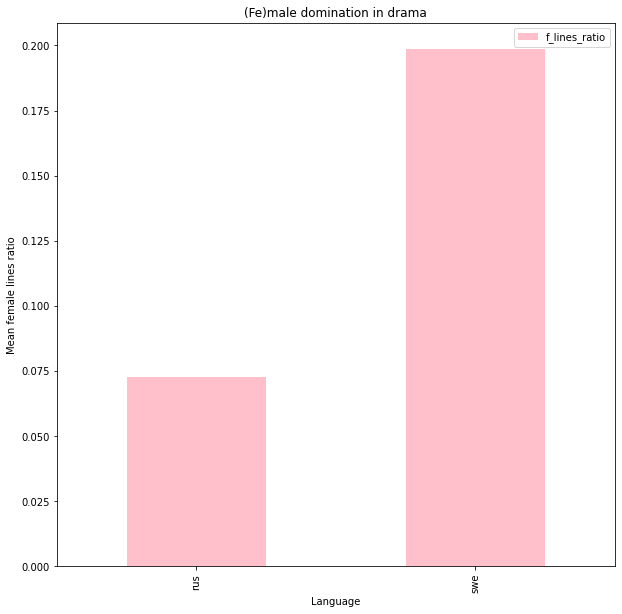

In [ ]:
df.groupby('lang_name').agg({"f_lines_ratio": "mean"}).sort_values(by="lang_name").plot.bar(color='pink', figsize=(10, 10))
plt.title('(Fe)male domination in drama')
plt.xlabel('Language')
plt.ylabel('Mean female lines ratio')

Реплики женских персонажей занимают меньше половины текста во всех языках -> гипотеза 2 подтвердилась

Text(0, 0.5, 'Gender of the main character')

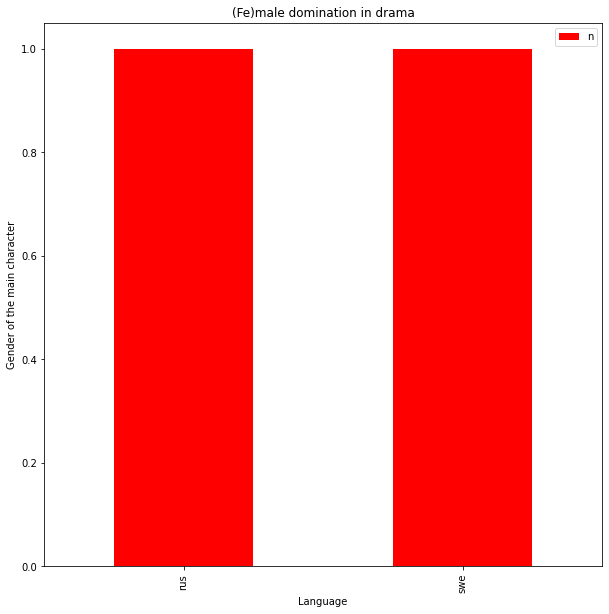

In [ ]:
s = df.groupby('lang_name')['main_character_gender'].value_counts(normalize=True).to_frame('n').reset_index().plot.bar(x='lang_name', y='n',color=df['main_character_gender'].map({'MALE':'red','FEMALE':'pink'}), figsize=(10, 10))
plt.title('(Fe)male domination in drama')
plt.xlabel('Language')
plt.ylabel('Gender of the main character')


Главные персонажи мужского пола встречаются чаще в языках -> Гипотеза 3 подтвердилась

In [ ]:
con = sqlite3.connect("drama.db")
c = con.cursor()

act_query = """
SELECT emotionality.play_id, char_id, gender, n_of_exclamation, lang_name, year 
FROM emotionality
    LEFT OUTER JOIN male_female_ratio ON emotionality.play_id = male_female_ratio.play_id
"""

df = pd.read_sql_query(act_query, con=con)
print(df.head())

con.close()

     play_id      char_id  gender  n_of_exclamation lang_name  year
0  rus000157   krivosudov    MALE          0.272993       rus  1802
1  rus000157       provor    MALE          0.255605       rus  1802
2  rus000157       milena  FEMALE          0.250000       rus  1802
3  rus000157  podryadchik    MALE          0.210526       rus  1802
4  rus000157      pravdin    MALE          0.168750       rus  1802


Text(0, 0.5, 'Ratio of exclamation female lines to all exclamation lines')

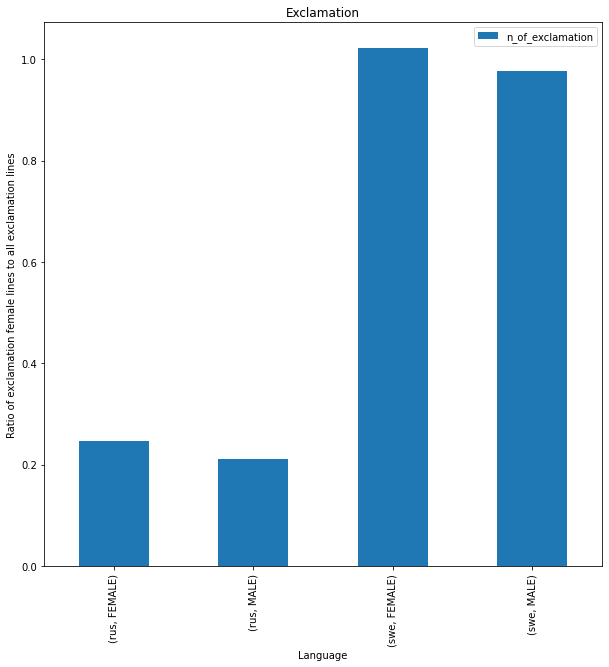

In [ ]:

s = df.groupby(['lang_name', 'gender']).agg({"n_of_exclamation": "mean"}).plot.bar(figsize=(10, 10))
plt.title('Exclamation')
plt.xlabel('Language')
plt.ylabel('Ratio of exclamation female lines to all exclamation lines')

Доля восклицательных реплик меньше у мужчин (хотя и немного) и сильно различается по языкам: в российский пьсах персонажи меньше восклицают, чем в шведских (хотя скорее всего, это глюк).

In [ ]:
col = {'MALE':'red','FEMALE':'pink'}
fig, ax = plt.subplots()
ax.scatter(x=df['year'], y=df['n_of_exclamation'], c=df['gender'].map(col))  # drawing the dots
plt.title("Exclamation")
plt.xlabel("Year")
plt.ylabel("ratio of exclamation")
plt.show()

Тут я думала связать это с нахождением протагониста не по длине, а по количеству связей, и уже так смотреть на пол, но не нашла в апи, как получить данные все разом.

Поэтому граф только для одной случайной пьесы бонусом:


In [ ]:
df = pd.read_csv('frogs.csv', sep=',', encoding='utf-8')
id_char = {'id': [], 'char': []}
G = nx.Graph()
labels = {}

for i, character in enumerate(set(df['Source'].tolist() + df['Target'].tolist())):
  print(i, character)
  id_char['id'].append(i)
  id_char['char'].append(character)
  G.add_node(i, label=character)
  labels[i] = character

id_char = pd.DataFrame(id_char)

df['Source'] = df['Source'].map(id_char.set_index('char')['id'])
df['Target'] = df['Target'].map(id_char.set_index('char')['id'])

for tup in list(df.itertuples(index=False, name=None)):
  source, target, weight = tup[0], tup[2], tup[3]
  G.add_edge(source, target, weight=weight)


0 Maid-Servant
1 Chorus of Frogs
2 Dionysus
3 Aeacus
4 Plathane
5 Xanthias
6 Pluto
7 Hostess
8 Euripides
9 Heracles
10 Charon
11 Aeschylus
12 Chorus
13 Corpse
14 Chorus Leader
15 Chorus of Blessed Mystics


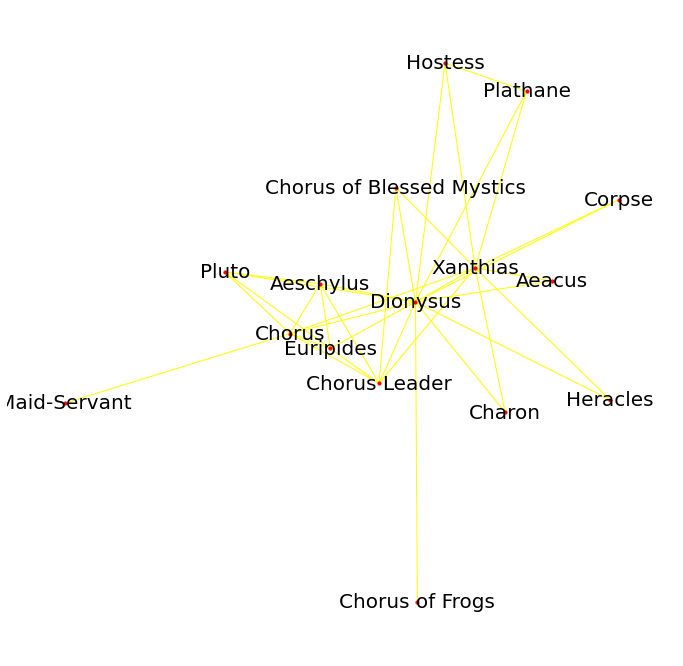

In [ ]:
pos=nx.spring_layout(G)# choosing a layout
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color='red', node_size=10) # color and size of the nodes
nx.draw_networkx_edges(G, pos, edge_color='yellow') # color of edges
nx.draw_networkx_labels(G, pos, labels=labels, font_size=20, font_family='Arial')# adding the labels
plt.axis('off') 
plt.show()